# 動機を持つ人

In [1]:
# load modules
from rdflib import Graph, URIRef

from glob import glob
import json
import sys

sys.path.append('../src/')
from utils import *

In [2]:
knowledge_graph_dir = '../KnowledgeGraph/'
additional_knowledge_graph_dir = '../AdditionalKnowledgeGraph/'

In [3]:
# %%html
# <!-- pandas.DataFrame の表示設定 -->
# <style>
# /* Any CSS style can go in here. */
# .dataframe th {
#     font-size: 14px;
# }
# .dataframe td {
#     font-size: 14px;
# }
# </style>


In [4]:
# load knowledge graph
filenames = [
  f'{knowledge_graph_dir}/SpeckledBand_mod.ttl', 
  f'{additional_knowledge_graph_dir}/human_environment.ttl', 
  f'{additional_knowledge_graph_dir}/additional_situation.ttl', 
  f'{additional_knowledge_graph_dir}/close_relation.ttl']
g = Graph()
g = load_rdf_files(g, filenames)

In [5]:
prefixes = dict(g.namespaces())
for prefix, uri in prefixes.items():
  print(prefix, uri)

xml http://www.w3.org/XML/1998/namespace
rdf http://www.w3.org/1999/02/22-rdf-syntax-ns#
rdfs http://www.w3.org/2000/01/rdf-schema#
xsd http://www.w3.org/2001/XMLSchema#
owl http://www.w3.org/2002/07/owl#
cc http://creativecommons.org/ns#
kgc http://kgc.knowledge-graph.jp/ontology/kgc.owl#
kd http://kgc.knowledge-graph.jp/data/SpeckledBand/
kgcf http://kgchallenge.github.io/ontology/
kdf http://kgchallenge.github.io/data/
agrelon http://d-nb.info/standards/elementset/agrelon#


### お金が絡むシーンを探してみる

In [6]:
# お金に言及していそうなシーンのIDを検索
q = '''
SELECT DISTINCT ?scene {
  {
    # kd:money は ttl ファイルを検索すると見つかる         
    ?scene kgc:what kd:money . 
  } UNION {
    ?scene kgc:subject kd:money .
  }
} ORDER by ?scene
'''

results = g.query(q, initBindings=dict(g.namespaces()))
pretty_print(results, g.namespace_manager)

,scene
0,kd:12
1,kd:13
2,kd:147
3,kd:15
4,kd:16
5,kd:18
6,kd:4
7,kd:6
8,kd:7


In [ ]:
# 上記 ID のシーンを確認してみる
print_scene = create_print_scene(g)
for b in results.bindings:
  idx = b['scene'].n3(g.namespace_manager)
  print(f'===== scene: {idx} =====')
  print_scene(idx)

## ルールを作る

### 概要 : (candidate, motivation, target) を特定するルールを作る
- ルールは motivation ごとに作る
- ルール適用時に少なくとも，candidate, target を特定する

In [8]:
rules = dict()

## 金欲

#### ルール

In [9]:
q = '''
SELECT DISTINCT ?candidate ?target {
  VALUES ?lose {kd:give kd:pay kd:lose} .
  VALUES ?get  {kd:have} .
  
  ?target a kgc:Person.
  ?subject a kgc:Person.
  
  # subject/whom がお金を get/lose で４パターン
  {
    ?scene kgc:what    kd:money ;
           kgc:subject ?candidate ;
           kgc:hasPredicate ?lose ;
           kgc:if ?if .
  } UNION {
    ?scene kgc:what    kd:money ;
           kgc:subject ?candidate ;
           kgc:hasPredicate ?get ;
           kgc:if ?if .
  } UNION {
    ?scene kgc:what    kd:money ;
           kgc:whom ?candidate ;
           kgc:hasPredicate ?get ;
           kgc:if ?if .
  } UNION {
    ?scene kgc:what    kd:money ;
           kgc:whom ?candidate ;
           kgc:hasPredicate ?lose ;
           kgc:if ?if .
  }

  # 条件分の subject と whom がターゲット
  {  
    ?if kgc:whom ?target .
  } UNION {
    ?if kgc:subject ?target .
  }
  
  
} ORDER by ?scene
'''

rules['greed_for_money'] = q
res = g.query(q)
pretty_print(res, g.namespace_manager)

,candidate,target
0,kd:Roylott,kd:Helen
1,kd:Roylott,kd:Julia


### 自己防衛

#### ルール

In [11]:
q = '''
SELECT DISTINCT ?candidate ?target
WHERE {
  VALUES ?pred_of_beScare {kd:beScared kd:beCruellyUsed} .
  VALUES ?pred_of_scare {kd:scared kd:cruellyUsed} .
  ?subclass_of_scene rdfs:subClassOf kgc:Scene .
    
  ?candidate a kgc:Person .

  {
    ?situation a ?subclass_of_scene;
               kgc:hasPredicate ?pred_of_beScare ;
               kgc:subject ?candidate ;
               kgc:whom ?target .
  } UNION { 
    ?situation a ?subclass_of_scene;
               kgc:hasPredicate ?pred_of_scare  ;
               kgc:subject ?target ;
               kgc:whom ?candidate .
  }
}
'''

rules['self_defence'] = q
res = g.query(q)
pretty_print(res, g.namespace_manager)

,candidate,target
0,kd:villager_of_Stoke_Moran,kd:Roylott
1,kd:Helen,kd:Roylott


追加した知識

#### 追加した知識

In [12]:
! cat {additional_knowledge_graph_dir}/additional_situation.ttl 

# additional_situation.ttl
# 本文の情報をもとに追加したナレッジ

@prefix kgc: <http://kgc.knowledge-graph.jp/ontology/kgc.owl#> .
@prefix kd: <http://kgc.knowledge-graph.jp/data/SpeckledBand/> .
@prefix kgcf: <http://kgchallenge.github.io/ontology/> .
@prefix kdf:  <http://kgchallenge.github.io/data/> .
@prefix owl: <http://www.w3.org/2002/07/owl#> .
@prefix rdfs: <http://www.w3.org/2000/01/rdf-schema#> .


# 小説中の"村の人々はすっかりおびえてしまい"の一文より
kdf:_023 a kgc:Situation ;
        kgc:source "村の人々はすっかりおびえてしまい、"@ja ;
        kgc:subject kd:villager_of_Stoke_Moran ;
        kgc:hasPredicate kd:beScared;
        kgc:whom kd:Roylott . # 文脈からロイロットだと判断

# 小説中の"「ひどい扱いを受けていらっしゃる。」ホームズが言った。"より
kdf:_129_1 a kgc:Situation ;
        kgc:source "「ひどい扱いを受けていらっしゃる。」ホームズが言った。"@ja ;
        kgc:subject kd:Holmes ; 
        kgc:hasPredicate kd:say ;
        kgc:what  kd:_129_2 .

kdf:_129_2 a kgc:Situation ;
        kgc:source "ひどい扱いを受けていらっしゃる。"@ja ; 
        kgc:subject kd:Helen ; # 文脈的にヘレン
        kgc:whom kd:Roylott;   # 文脈的にロ

# 怨恨

#### ルール

In [14]:
q = '''
SELECT DISTINCT ?candidate ?target
WHERE {  
  VALUES ?pred_of_think {kd:suspect} .
  ?subclass_of_scene rdfs:subClassOf kgc:Scene .

  # 誰かが死んだシーン
  ?die_situation a ?subclass_of_scene ;
                 kgc:hasPredicate kd:die ; #kd:beKilledの方がよい？
                 kgc:subject ?dead_person .

  # 死人と近い関係にあった人
  ?relation_of_close_person a kgcf:relation_of_family .
  ?candidate ?relation_of_close_person ?dead_person .

  # 殺人犯に当たりがついているか
  ?think_situatoin a ?subclass_of_scene ; 
                   kgc:hasPredicate ?pred_of_think ;
                   kgc:subject ?candidate ;
                   kgc:what ?action .
  {
    ?action a ?subclass_of_scene ;
            kgc:subject ?killer ;
            kgc:whom ?dead_person ;
            kgc:hasPredicate kd:kill ; 
            kgcf:hasAttribution kd:uncertainly .
  } UNION {
    ?action a ?subclass_of_scene ;
            kgc:subject ?dead_person ;
            kgc:whom ?killer ;
            kgc:hasPredicate kd:beKilled ;
            kgcf:hasAttribution kd:uncertainly .
  }
}

'''

rules['rancor'] = q
res = g.query(q)
pretty_print(res, g.namespace_manager)

,candidate,target


### 結果を Knowledge Graph に追加する

#### 追加した知識

In [15]:
! cat {additional_knowledge_graph_dir}/close_relation.ttl

# close_relation.ttl
# 肉親にあたる関係
@prefix kgc: <http://kgc.knowledge-graph.jp/ontology/kgc.owl#> .
@prefix kd: <http://kgc.knowledge-graph.jp/data/SpeckledBand/> .
@prefix kgcf: <http://kgchallenge.github.io/ontology/> .
@prefix kdf: <http://kgchallenge.github.io/data/> .
@prefix rdfs: <http://www.w3.org/2000/01/rdf-schema#> .
@prefix rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#> .

@prefix agrelon: <http://d-nb.info/standards/elementset/agrelon#> .

kgcf:relation_of_family a rdf:Class .


agrelon:hasParentInlaw a kgcf:relation_of_family .
agrelon:hasBiologicalSibling a kgcf:relation_of_family .
agrelon:hasChildInlaw a kgcf:relation_of_family .
agrelon:hasBiologicalChild a kgcf:relation_of_family .
agrelon:hasSpouse a kgcf:relation_of_family .



In [16]:
! cat {additional_knowledge_graph_dir}/human_environment.ttl

# human_environment.ttl
# 登場人物の関係(一部)
@prefix kgc: <http://kgc.knowledge-graph.jp/ontology/kgc.owl#> .
@prefix kd: <http://kgc.knowledge-graph.jp/data/SpeckledBand/> .
@prefix kgcf: <http://kgchallenge.github.io/ontology/> .
@prefix kdf:  <http://kgchallenge.github.io/data/> .
@prefix owl: <http://www.w3.org/2002/07/owl#> .
@prefix rdfs: <http://www.w3.org/2000/01/rdf-schema#> .

@prefix agrelon: <http://d-nb.info/standards/elementset/agrelon#> .

kd:Helen agrelon:hasParentInlaw kd:Roylott .
kd:Julia agrelon:hasParentInlaw kd:Roylott .

kd:Helen agrelon:hasBiologicalSibling kd:Julia .
kd:Julia agrelon:hasBiologicalSibling kd:Helen .

kd:Roylott agrelon:hasChildInlaw kd:Helen ;
           agrelon:hasChildInlaw kd:Julia .
kd:mother_of_Helen agrelon:hasBiologicalChild kd:Helen .
kd:mother_of_Helen agrelon:hasBiologicalChild kd:Julia .
kd:mother_of_Julia agrelon:hasBiologicalChild kd:Helen .
kd:mother_of_Julia agrelon:hasBiologicalChild kd:Julia .
kd:mother_of_sister agrelon:hasBiologicalC

### ルール適用時に得られた推論結果を Knowledge Graph 追加

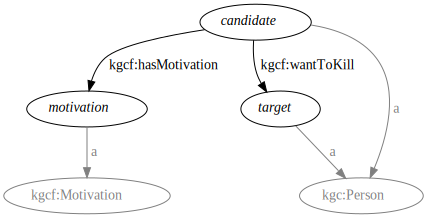

In [17]:
dot = '''
  digraph motivation {
  candidate [label=<<I>candidate</I>>]
  motivation [label=<<I>motivation</I>>]
  target [label=<<I>target</I>>]
  person_class [label=<kgc:Person>, color=gray, fontcolor=gray]
  motivation_class [label=<kgcf:Motivation>, color=gray, fontcolor=gray]
  
  candidate -> motivation [label=<  kgcf:hasMotivation>];
  candidate -> target [label=<  kgcf:wantToKill>];
  candidate -> person_class [label=<  a>, color=gray, fontcolor=gray]
  target -> person_class [label=<  a>, color=gray, fontcolor=gray]
  motivation -> motivation_class [label=<  a>, color=gray, fontcolor=gray]
  
}
'''
binary_image = pydotplus.graph_from_dot_data(dot).create_svg()
SVG(binary_image)

In [18]:
# URIの用意
## Predicates
has_motivation  = prefixes['kgcf'] + URIRef('hasMotivation')
want_to_kill    = prefixes['kgcf'] + URIRef('wantToKill')

## Motivations
greed_for_money = prefixes['kdf'] + URIRef('greed_for_money')
rancor          = prefixes['kdf'] + URIRef('rancor')
self_defence    = prefixes['kdf'] + URIRef('self_defence')

In [19]:
motivations = [greed_for_money, self_defence, rancor]
for i, motivation in enumerate(motivations):
  q = rules[motivation.split('/')[-1]]
  for row in g.query(q):
    candidate, target = row
    triples = [
      (candidate, has_motivation, motivation),
      (candidate, want_to_kill, target),
    ]
    
    g = insert(g, triples)

## 殺人動機を持つ人物の検索

In [20]:
q = '''
SELECT DISTINCT ?candidate ?motivation ?target 
WHERE {
  ?candidate kgcf:hasMotivation ?motivation ;
             kgcf:wantToKill    ?target .
}
'''

res = g.query(q)
pretty_print(res, g.namespace_manager)

,candidate,motivation,target
0,kd:Roylott,kdf:greed_for_money,kd:Helen
1,kd:Roylott,kdf:greed_for_money,kd:Julia
2,kd:villager_of_Stoke_Moran,kdf:self_defence,kd:Roylott
3,kd:Helen,kdf:self_defence,kd:Roylott
